In [1]:
using Statistics, Unitful, DSP, LaTeXStrings, LinearAlgebra
using CairoMakie
import ColorSchemes: nord, tab10

# fg = :black  # nord[5]
# gg = :grey   # nord[3]
fg = nord[5]
gg = nord[3]
bg = :transparent

set_theme!(Theme(
    fontsize = 20,
    palette = ( color = tab10,),
    Axis = (
        backgroundcolor = bg,
        xtickcolor = fg, ytickcolor = fg,
        xgridcolor = gg, ygridcolor = gg,
        xlabelcolor = fg, ylabelcolor = fg,
        xticklabelcolor = fg, yticklabelcolor = fg,
        topspinecolor = fg, bottomspinecolor = fg,
        leftspinecolor = fg, rightspinecolor = fg,
        titlecolor = fg,
    ),
    Legend = (
        bgcolor = bg,
        labelcolor = fg, titlecolor = fg,
        framevisible = false, margin=(0,0,0,0)
    )
))



In [2]:
include("generate_data.jl")

Signal 1:    amplitude 1.4142135623730951, frequency 1.0 Hz, direction of arrival 0°
Signal 2:    amplitude 1.4142135623730951, frequency 1.0 Hz, direction of arrival -10°, rel. phase 45°
Noise: standard deviation 1.4142135623730951
Output vector x is size 10 elements by 100 time samples


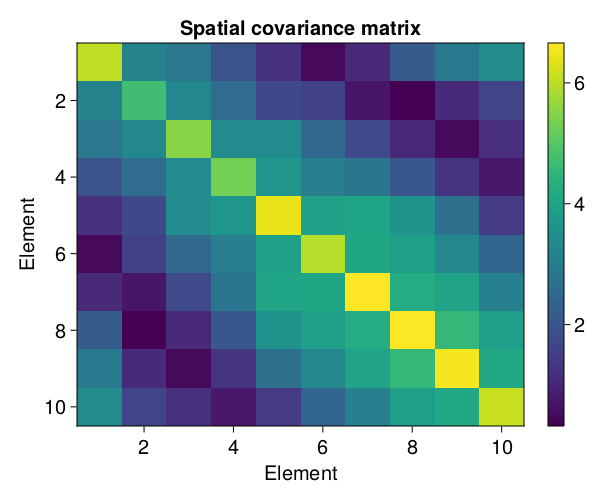

In [3]:
R = x*x' / N

F = Figure(backgroundcolor=bg, resolution=(600,500))
ax = Axis(F[1,1], yreversed=true, title="Spatial covariance matrix",
    xlabel="Element", ylabel="Element")
hm = heatmap!(ax, abs.(R))
cb = Colorbar(F[:,end+1], hm)
save("a.pdf", F)
F

In [4]:
DOA = -40°:0.25°:50°
ϕ(θ)     = -k*d*sin.(θ)
a(θ)     = @. exp(1im*ϕ(θ)*(0:M-1))

a (generic function with 1 method)

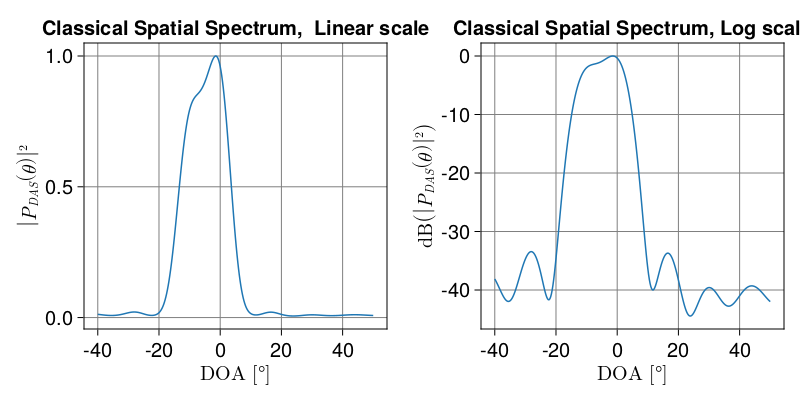

In [5]:
P_DAS(θ) = (a(θ)'*R*a(θ)) / M

# Normalize
P_BF = @. abs(P_DAS(DOA))^2
P_BF ./= maximum(P_BF);

F = Figure(backgroundcolor=bg, resolution=(800,400))
ax1 = Axis(F[1,1], title="Classical Spatial Spectrum,  Linear scale",
    xlabel=L"\text{DOA [\degree]}", ylabel=L"\left|P_{DAS}\left(\theta\right)\right|^2")
ax2 = Axis(F[1,2], title="Classical Spatial Spectrum, Log scale",
    xlabel=L"\text{DOA [\degree]}", ylabel=L"\text{dB}\left(\left|P_{DAS}\left(\theta\right)\right|^2\right)")
lines!(ax1,ustrip(DOA), P_BF)
lines!(ax2,ustrip(DOA), amp2db.(P_BF))
save("b.pdf", F)
F

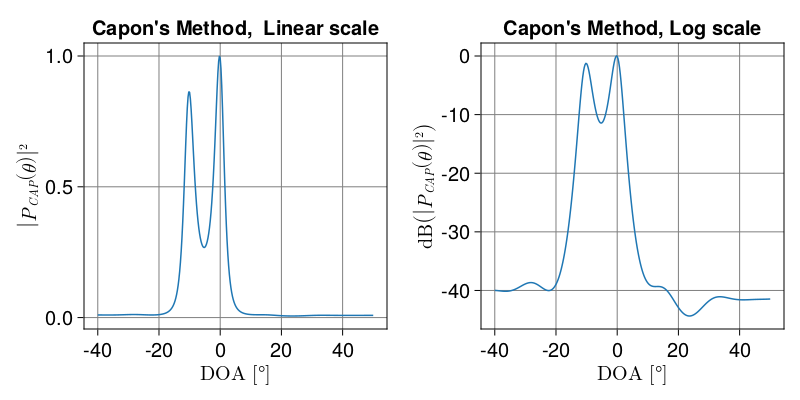

In [6]:
P_CAP(θ) = 1 / (a(θ)'*inv(R)*a(θ))

# Normalize
P_BF2 = @. abs(P_CAP(DOA))^2
P_BF2 ./= maximum(P_BF2);

F = Figure(backgroundcolor=bg, resolution=(800,400))
ax1 = Axis(F[1,1], title="Capon's Method,  Linear scale",
    xlabel=L"\text{DOA [\degree]}", ylabel=L"\left|P_{CAP}\left(\theta\right)\right|^2")
ax2 = Axis(F[1,2], title="Capon's Method, Log scale",
    xlabel=L"\text{DOA [\degree]}", ylabel=L"\text{dB}\left(\left|P_{CAP}\left(\theta\right)\right|^2\right)")
lines!(ax1,ustrip(DOA), P_BF2)
lines!(ax2,ustrip(DOA), amp2db.(P_BF2))
save("c.pdf", F)
F

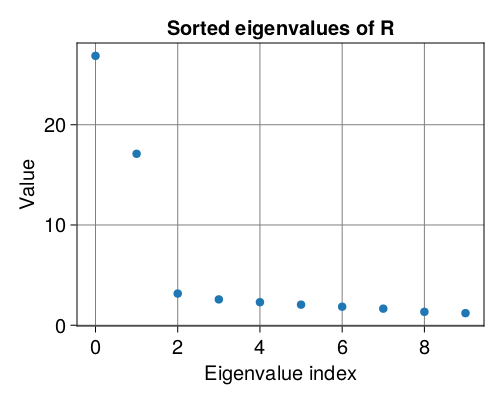

In [7]:
dd, V = eigvals(R), eigvecs(R);
reverse!(dd); reverse!(V, dims=2);
F = Figure(backgroundcolor=bg, resolution=(500,400))
ax = Axis(F[1,1], title="Sorted eigenvalues of R",
    xlabel="Eigenvalue index", ylabel="Value")
scatter!(ax, 0:M-1, dd)
save("d.pdf", F)
F

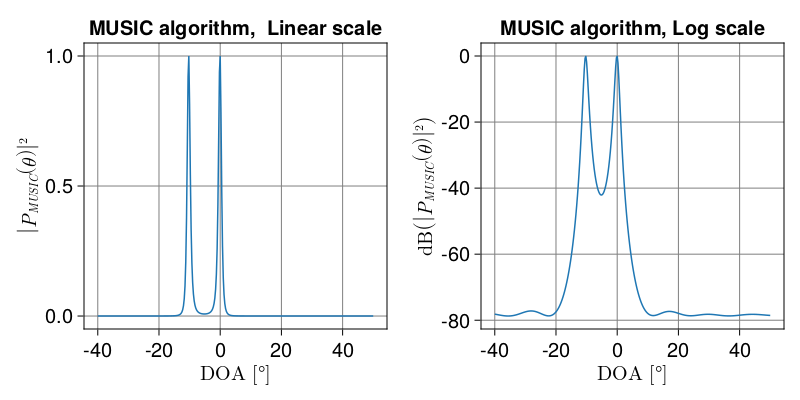

In [8]:
U = V[:, 3:end]
Π = U*U'
P_M(θ) = 1/(a(θ)'*Π*a(θ))

# Normalize
P_BF3 = @. abs(P_M(DOA))^2
P_BF3 ./= maximum(P_BF3);

F = Figure(backgroundcolor=bg, resolution=(800,400))
ax1 = Axis(F[1,1], title="MUSIC algorithm,  Linear scale",
    xlabel=L"\text{DOA [\degree]}", ylabel=L"\left|P_{MUSIC}\left(\theta\right)\right|^2")
ax2 = Axis(F[1,2], title="MUSIC algorithm, Log scale",
    xlabel=L"\text{DOA [\degree]}", ylabel=L"\text{dB}\left(\left|P_{MUSIC}\left(\theta\right)\right|^2\right)")
lines!(ax1,ustrip(DOA), P_BF3)
lines!(ax2,ustrip(DOA), amp2db.(P_BF3))
save("e.pdf", F)
F


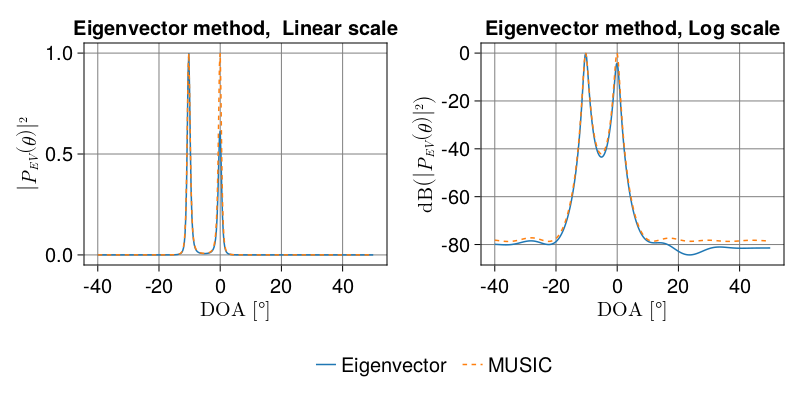

In [9]:
U = V[:, 3:end]
Λ⁻¹ = inv(diagm(dd[3:end]))
P_EV(θ) = 1/(a(θ)'*U*Λ⁻¹*U'*a(θ))

# Normalize
P_BF4 = @. abs(P_EV(DOA))^2
P_BF4 ./= maximum(P_BF4);

F = Figure(backgroundcolor=bg, resolution=(800,400))
ax1 = Axis(F[1,1], title="Eigenvector method,  Linear scale",
    xlabel=L"\text{DOA [\degree]}", ylabel=L"\left|P_{EV}\left(\theta\right)\right|^2")
ax2 = Axis(F[1,2], title="Eigenvector method, Log scale",
    xlabel=L"\text{DOA [\degree]}", ylabel=L"\text{dB}\left(\left|P_{EV}\left(\theta\right)\right|^2\right)")
eigl = lines!(ax1,ustrip(DOA), P_BF4)
musl = lines!(ax1,ustrip(DOA), P_BF3, linestyle=:dash)
lines!(ax2,ustrip(DOA), amp2db.(P_BF4))
lines!(ax2,ustrip(DOA), amp2db.(P_BF3), linestyle=:dash)
Legend(F[2,1:2], [eigl, musl], ["Eigenvector", "MUSIC"], orientation=:horizontal)
save("f.pdf", F)
F

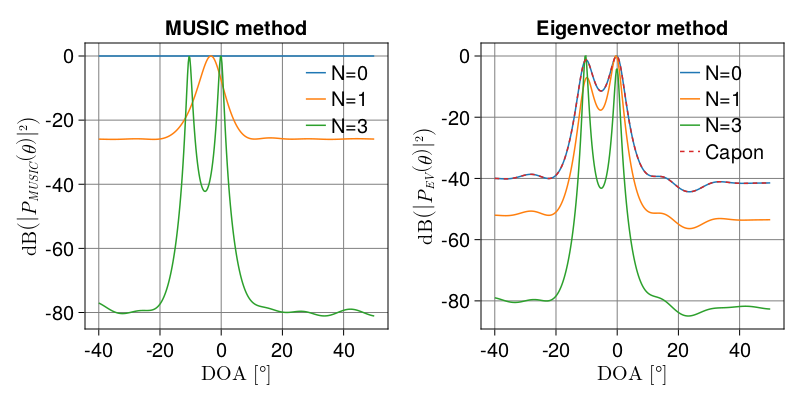

In [10]:
function assume_sources(N)
    U = V[:, N+1:end]
    Λ⁻¹ = inv(diagm(dd[N+1:end]))
    P0 = θ -> 1/(a(θ)'*U*U'*a(θ))
    P1 = θ -> 1/(a(θ)'*U*Λ⁻¹*U'*a(θ))
    return (
        (@. abs(P0(DOA))^2) |> x -> x ./ maximum(x),
        (@. abs(P1(DOA))^2) |> x -> x ./ maximum(x)
    )
end

F = Figure(backgroundcolor=bg, resolution=(800,400))
ax1 = Axis(F[1,1], title="MUSIC method",
    xlabel=L"\text{DOA [\degree]}", ylabel=L"\text{dB}\left(\left|P_{MUSIC}\left(\theta\right)\right|^2\right)")
ax2 = Axis(F[1,2], title="Eigenvector method",
    xlabel=L"\text{DOA [\degree]}", ylabel=L"\text{dB}\left(\left|P_{EV}\left(\theta\right)\right|^2\right)")

for N = [0, 1, 3]
    MUSIC, EV = assume_sources(N)
    lines!(ax1,ustrip(DOA), amp2db.(MUSIC), label="N=$N")
    lines!(ax2,ustrip(DOA), amp2db.(EV), label="N=$N")
end

lines!(ax2, ustrip(DOA), amp2db.(P_BF2), linestyle=:dash, label="Capon")

axislegend(ax1); axislegend(ax2);

save("g.pdf", F)
F

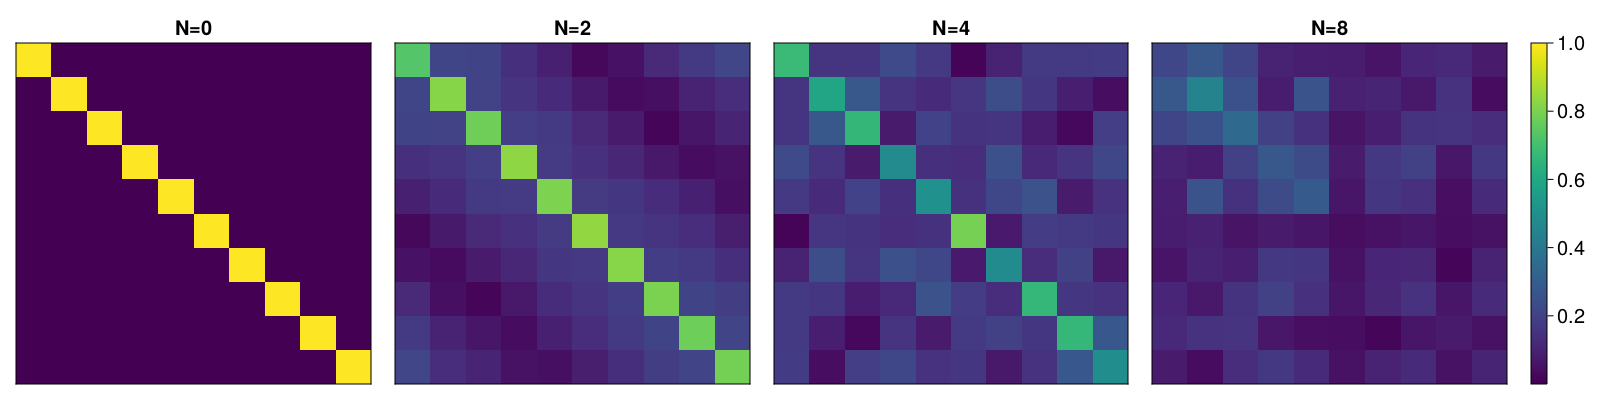

In [11]:
function MVDR_kernel(N_sources)
    U   = V[:, N_sources+1:end]
    Λ⁻¹ = inv(diagm(dd[N_sources+1:end]))
    return U*U'
end

F = Figure(backgroundcolor=bg, resolution=(1600,400))
N = [0, 2, 4, 8]

cmaps = zeros(length(N), 2)
hms = Vector{Heatmap}(undef, length(N))

for (i,n) in enumerate(N)
    ax = Axis(F[1,i], yreversed=true, title="N=$n")
    hidedecorations!(ax)

    hms[i] = heatmap!(ax, abs.(MVDR_kernel(n)))
    cmaps[i,:] = to_value(hms[i].colorrange)
end

crange = minimum(cmaps),maximum(cmaps)
map(hm -> hm.colorrange = crange, hms)
Colorbar(F[1,end+1], hms[1], vertical=true)

save("h.pdf", F)
F

In [12]:
K = MVDR_kernel(2)
@show abs(K[1,1])
@show sqrt(2)-1
;

abs(K[1, 1]) = 0.7336176821979521
sqrt(2) - 1 = 0.41421356237309515


In [13]:
include("generate_data2.jl")

Signal 1:    amplitude 1.4142135623730951, frequency 1.0 Hz, direction of arrival 20°
Signal 2:    amplitude 1.4142135623730951, frequency 1.0 Hz, direction of arrival -10°, rel. phase 45°
Noise: standard deviation 1.4142135623730951
Output vector x is size 10 elements by 100 time samples


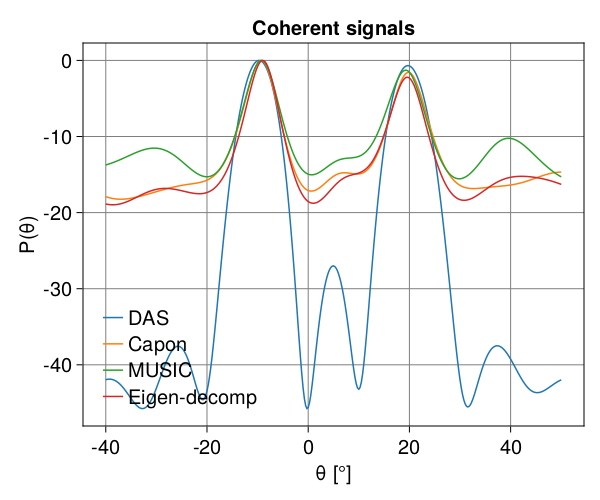

In [14]:
R = x*x' / N
dd, V = eigvals(R), eigvecs(R);
reverse!(dd); reverse!(V, dims=2);
U = V[:, 3:end]
Π = U*U'
Λ⁻¹ = inv(diagm(dd[3:end]))

P_DAS(θ) = (a(θ)'*R*a(θ)) / M
P_CAP(θ) = 1 / (a(θ)'*inv(R)*a(θ))
P_M(θ)   = 1/(a(θ)'*Π*a(θ))
P_EV(θ)  = 1/(a(θ)'*U*Λ⁻¹*U'*a(θ))

P_BF  = @. abs(P_DAS(DOA))^2; P_BF  ./= maximum(P_BF);
P_BF2 = @. abs(P_CAP(DOA))^2; P_BF2 ./= maximum(P_BF2);
P_BF3 = @. abs(P_M(DOA))^2;   P_BF3 ./= maximum(P_BF3);
P_BF4 = @. abs(P_EV(DOA))^2;  P_BF4 ./= maximum(P_BF4);

F = Figure(backgroundcolor=bg,resolution=(600,500))

ax = Axis(F[1,1], title="Coherent signals", xlabel="θ [°]", ylabel="P(θ)")
lines!(ax, ustrip(DOA), amp2db.(P_BF), label="DAS")
lines!(ax, ustrip(DOA), amp2db.(P_BF2), label="Capon")
lines!(ax, ustrip(DOA), amp2db.(P_BF3), label="MUSIC")
lines!(ax, ustrip(DOA), amp2db.(P_BF4), label="Eigen-decomp")
axislegend(ax, position=:lb)
save("i.pdf", F)
F
